<a href="https://colab.research.google.com/github/Toon-nooT/notebooks/blob/main/Donut_vs_pix2struct_1_Ghega_data_prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook i will demonstrate how to convert data (here the Ghega dataset) into a format for finetuning Donut and Pix2Struct transformer models.
See medium article:

### Data preparation

In [1]:
import os
import pandas as pd
import shutil
import random
import re
from os.path import isfile,join
from IPython.display import Image


download [ghega dataset](https://machinelearning.inginf.units.it/data-and-tools/ghega-dataset) and unzip

In [2]:
!gdown 0B-OtkIZlzfTnMGYxMjgzNjUtY2E2MC00NWZiLTk3NWYtYjQ5NTI0MzNlMzQx

Downloading...
From: https://drive.google.com/uc?id=0B-OtkIZlzfTnMGYxMjgzNjUtY2E2MC00NWZiLTk3NWYtYjQ5NTI0MzNlMzQx
To: /content/ghega-dataset.zip
100% 60.4M/60.4M [00:01<00:00, 38.4MB/s]


In [3]:
!unzip -qo /content/ghega-dataset.zip # -d /content/

Folder structure looks like this:
```
ghega-dataset
    datasheets
        central-zener-1
        central-zener-2
        diodes-zener
            document-000-123542.blocks.csv
            document-000-123542.groundtruth.csv
            document-000-123542.in.000.png
            document-000-123542.out.000.png
            document-001-123663.blocks.csv
            document-001-123663.groundtruth.csv
            document-001-123663.in.000.png
            document-001-123663.out.000.png
            ...
        mcc-zener
        ...
    patents
        ...
```



Ghega dataset has two document types: datasheets and patents. These are the indexes collected:

*data-sheets:*
Model, Type, Case, Power Dissipation, Storage Temperature, Voltage, Weight, Thermal Resistance

*patents:*
Title, Applicant, Inventor, Representative, Filing Date, Publication Date, Application Number, Publication Number, Priority, Classification, Abstract 1st line

Looking at the quality of the ground truth and feasibility i choose the following indexes

In [4]:
elements_to_extract = ['FilingDate', 'RepresentiveFL', 'Classification', 'PublicationDate','ApplicationNumber','Model','Voltage','StorageTemperature']


Use dataframe to collect info for stats and sanity check

In [5]:
ghega_df = pd.DataFrame(columns = elements_to_extract+['DocType','ImagePath'])

Process dataset into donut format.
Which means one folder with many image files and a jsonl file
However, i want to split already here into train and validation, for better comparison between donut and pix2struct

In [6]:
#output folder for new dataset
os.mkdir('/content/dataset')
os.mkdir('/content/dataset/train')
os.mkdir('/content/dataset/validation')

In [7]:
json_lines_train = ''
json_lines_val = ''

for dirpath, dirnames, filenames in os.walk('/content/ghega-dataset/'):
    for filename in filenames:
        if filename.endswith('in.000.png'):
          gt_filename = filename.replace('in.000.png','groundtruth.csv')
          gt_filename_path = os.path.join(dirpath, gt_filename)
          if not os.path.exists(gt_filename_path):    #ignore files in /ghega-dataset/datasheets/taiwan-switching/ because no groundtruth exists
            continue
          if os.path.getsize(gt_filename_path) == 0:  #ignore empty groundtruth files
            print(f'skipped {gt_filename_path} because no info in metadata')
            continue
          doc_df = pd.read_csv(gt_filename_path, header=None)
          #find the doctype, based on path
          if 'patent' in dirpath:
            type = 'patent'
          else:
            type = 'datasheet'
          #create json line
          #eg:
          #{"file_name": "document-034-127420.in.000.png", "ground_truth": "{\"gt_parse\": { \"DocType\": \"datasheet\", \"Model\": \"ZMM5221 B - ZMM5267B\", \"Voltage\": \"1.5\", \"StorageTemperature\": \"-65 to 175\" } }"}
          p2 = ''
          #add always first element: DocType
          p2 += '\\"' + 'DocType' + '\\": '
          p2 += '\\"' + type + '\\"'
          new_row = {'ImagePath': os.path.join(dirpath, filename), 'DocType' :type}
          ghega_df = pd.concat([ghega_df, pd.DataFrame([new_row])], ignore_index=True)
          #fill other elements if available
          for element in elements_to_extract:
            value = doc_df[doc_df[0] == element][12].tolist()
            if len(value) > 0:
              p2 += ', '
              p2 += '\\"' + element + '\\": '
              value = re.sub(r'[^A-Za-z0-9 ,.()/-]+', '', value[0])   #get rid of \ of ” and " in json
              p2 += '\\"' + value + '\\"'
              new_row = {'ImagePath': os.path.join(dirpath, filename), element :value}
              ghega_df = pd.concat([ghega_df, pd.DataFrame([new_row])], ignore_index=True)

          p3 = ' } }"}'

          json_line = p1 + p2 + p3
          print(json_line)

          #take ~20% to validation
          #copy image file and append json line
          if random.randint(1, 100) < 20:
            output_path = '/content/dataset/validation/'
            json_lines_val += json_line + '\r\n'
            shutil.copy(os.path.join(dirpath, filename), '/content/dataset/validation/')  
          else:
            output_path = '/content/dataset/train/'
            json_lines_train += json_line + '\r\n'
            shutil.copy(os.path.join(dirpath, filename), '/content/dataset/train/')  
       
#write jsonl files
text_file = open('/content/dataset/train/metadata.jsonl', "w")
text_file.write(json_lines_train)
text_file.close()
text_file = open('/content/dataset/validation/metadata.jsonl', "w")
text_file.write(json_lines_val)
text_file.close()

#zip folder for easy download
!zip -qr /content/dataset.zip /content/dataset/        



{"file_name": "document-000-106848.in.000.png", "ground_truth": "{\"gt_parse\": { \"DocType\": \"patent\", \"FilingDate\": \"09.12.2008\", \"RepresentiveFL\": \"Kiehl, Hubert etal\", \"Classification\": \"A47J 31/40 (26)\", \"PublicationDate\": \"17.06.2009\", \"ApplicationNumber\": \"08356151.4\" } }"}
{"file_name": "document-001-106931.in.000.png", "ground_truth": "{\"gt_parse\": { \"DocType\": \"patent\", \"FilingDate\": \"02.12.2008\", \"RepresentiveFL\": \"Kiehl, Hubert etal\", \"Classification\": \"A47J 31/40 (26)\", \"PublicationDate\": \"10.06.2009\", \"ApplicationNumber\": \"08356148.0\" } }"}
{"file_name": "document-005-107572.in.000.png", "ground_truth": "{\"gt_parse\": { \"DocType\": \"patent\", \"FilingDate\": \"10. Dczcmbci 2003 (10.12.2003)\", \"Classification\": \"B62B 7/08\", \"PublicationDate\": \"15. Juli 2004 (15.07.2004)\" } }"}
{"file_name": "document-011-108389.in.000.png", "ground_truth": "{\"gt_parse\": { \"DocType\": \"patent\", \"FilingDate\": \"3. Oktober 20

## sanity check

In [8]:
ghega_df.describe()

,FilingDate,RepresentiveFL,Classification,PublicationDate,ApplicationNumber,Model,Voltage,StorageTemperature,DocType,ImagePath
count,123,73,122,121,130,53,77,107,245,1051
unique,115,59,109,105,130,53,50,73,2,245
top,08.12.2000,"de Rivera de Elzaburu, Alfonso",A47J 31/40,22.07.2009,08356151.4,MSE z,I 6,-65 to 150,patent,/content/ghega-dataset/patents/espacenet-fr/do...
freq,3,3,6,4,1,1,6,10,135,6


In [9]:
#get random row
randomimgpath = ghega_df.sample(n = 1)['ImagePath'].values[0]

print(randomimgpath)
#get all values for this image
print(ghega_df.loc[ghega_df['ImagePath'] == randomimgpath])

/content/ghega-dataset/patents/spagna/document-014-100539.in.000.png
     FilingDate             RepresentiveFL Classification PublicationDate  \
213         NaN                        NaN            NaN             NaN   
214  20.02.1997                        NaN            NaN             NaN   
215         NaN  Elzaburu Marquez, Alberto            NaN             NaN   
216         NaN                        NaN    A61 K 39/39             NaN   
217         NaN                        NaN            NaN         0889736   
218         NaN                        NaN            NaN             NaN   

    ApplicationNumber Model Voltage StorageTemperature DocType  \
213               NaN   NaN     NaN                NaN  patent   
214               NaN   NaN     NaN                NaN     NaN   
215               NaN   NaN     NaN                NaN     NaN   
216               NaN   NaN     NaN                NaN     NaN   
217               NaN   NaN     NaN                NaN     Na

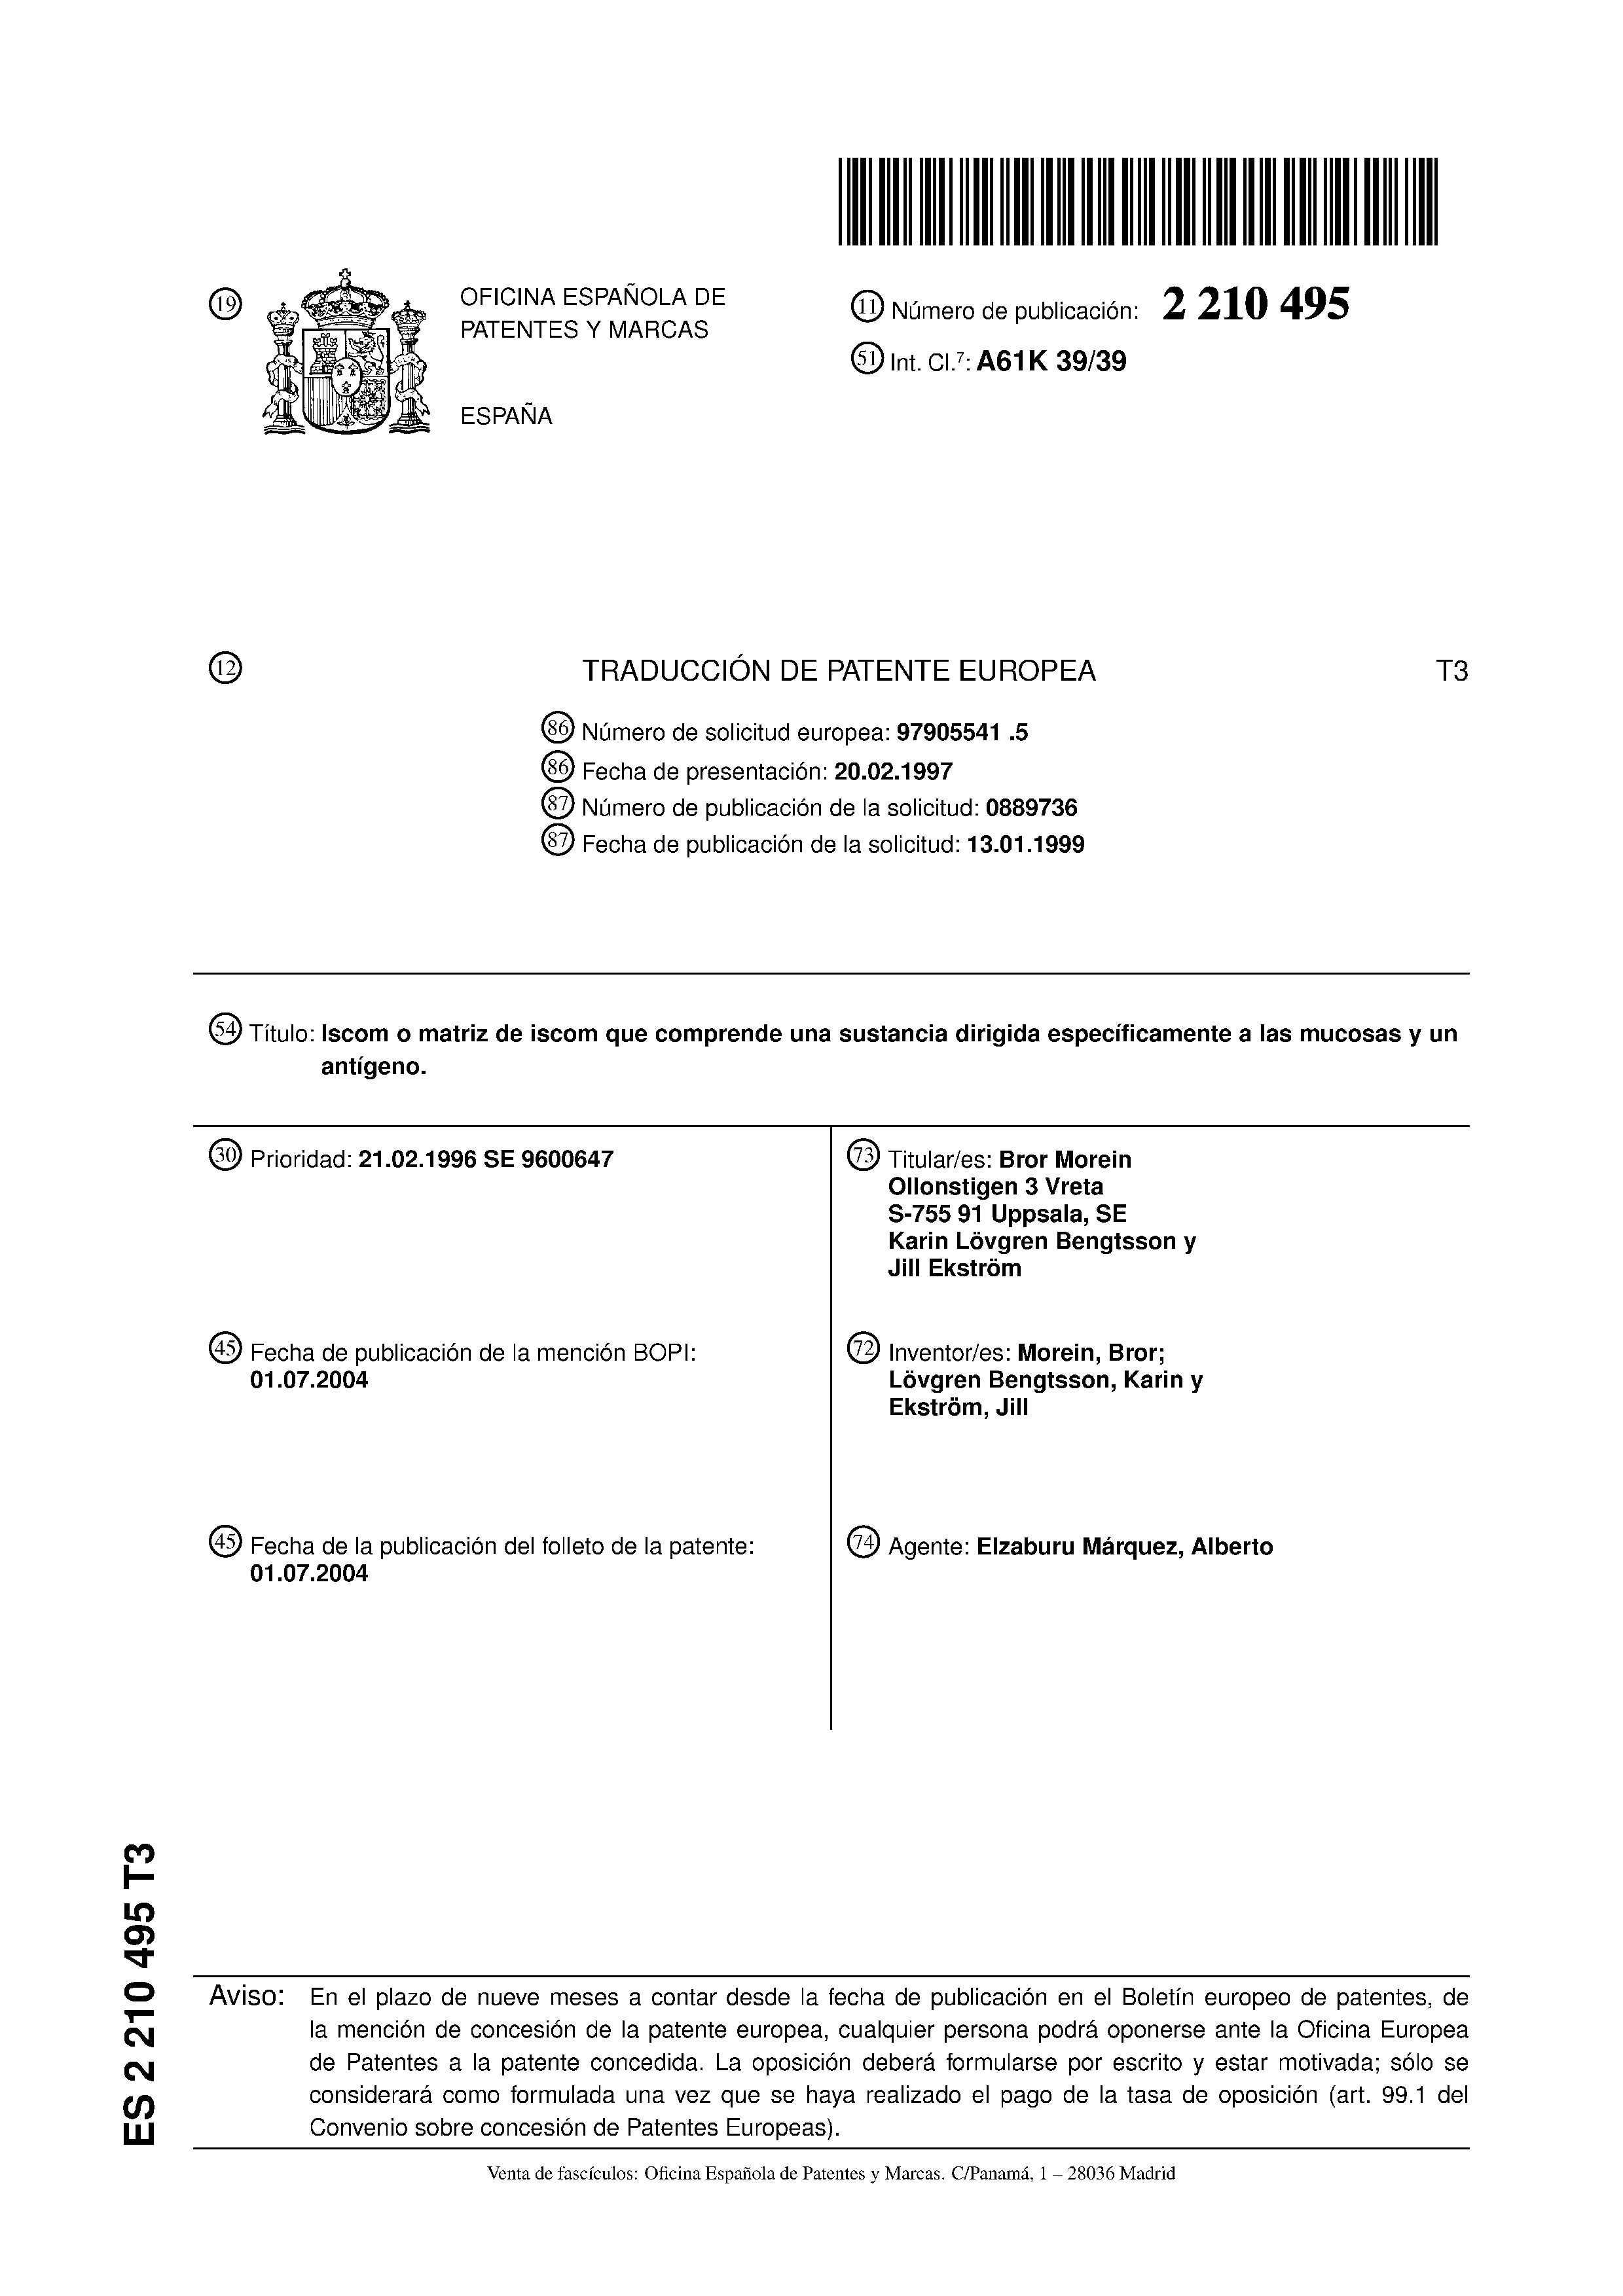

In [10]:
Image(filename=randomimgpath,width=800,height=1100)